# CSC420 Assignment 4 Implementation Task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [16]:
# cap = cv2.VideoCapture(0) # camera feed
cap = cv2.VideoCapture("Q5/KylianMbappe.mp4") # video

# capture one frame
ret,frame = cap.read()

# detect a face on the first frame
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_boxes = face_detector.detectMultiScale(frame)


if len(face_boxes)==0:
    print('no face detected')
    assert(False)

# initialize the tracing window around the (first) detected face
(x,y,w,h) = tuple(face_boxes[1])
track_window = (x,y,w,h)

#  region of interest for tracking
roi = frame[y:y+h, x:x+w]

# convert the roi to HSV so we can construct a histogram of Hue
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# why do we need this mask? (remember the cone?)
# read the description for Figure 3 in the original Cam Shift paper: http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.14.7673
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))


# form histogram of hue in the roi
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])

# normalize the histogram array values so they are in the min=0 to max=255 range
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# termination criteria for mean shift: 10 iteration or shift less than 1 pixel
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

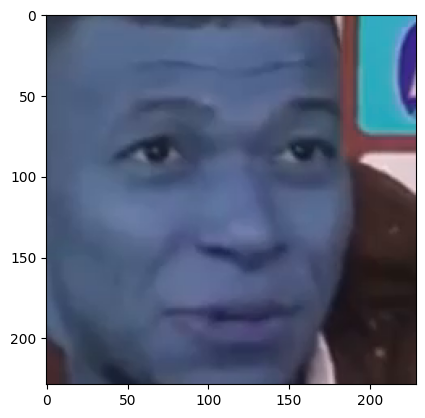

In [17]:
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.imshow(roi)

In [18]:

if len(face_boxes)==0:
    print('no face detected')
    assert(False)

# initialize the tracing window around the (first) detected face
(x,y,w,h) = tuple(face_boxes[1])
track_window = (x,y,w,h)

#  region of interest for tracking
roi = frame[y:y+h, x:x+w]

# convert the roi to HSV so we can construct a histogram of Hue
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# why do we need this mask? (remember the cone?)
# read the description for Figure 3 in the original Cam Shift paper: http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.14.7673
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))


# form histogram of hue in the roi
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])

# normalize the histogram array values so they are in the min=0 to max=255 range
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# termination criteria for mean shift: 10 iteration or shift less than 1 pixel
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while True:

    # grab a frame
    ret ,frame = cap.read()

    if ret == True:

        # convert to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # histogram back projection using roi_hist
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # use meanshift to shift the tracking window
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # display tracked window
        x,y,w,h = track_window
        img = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255),5)

        cv2.imshow('mean shift tracking demo',img)

        if cv2.waitKey(33) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break

    else:
        break

cv2.destroyAllWindows()
cap.release()

In [19]:
# cap = cv2.VideoCapture(0) # camera feed
cap = cv2.VideoCapture("Q5/KylianMbappe.mp4") # video


# capture one frame
ret,frame = cap.read()

# detect a face on the first frame
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_boxes = face_detector.detectMultiScale(frame)

if len(face_boxes)==0:
    print('no face detected')
    assert(False)

# initialize the tracing window around the (first) detected face
(x,y,w,h) = tuple(face_boxes[1])
track_window = (x,y,w,h)

#  region of interest for tracking
roi = frame[y:y+h, x:x+w]

# convert the roi to HSV so we can construct a histogram of Hue
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# why do we need this mask? (remember the cone?)
# read the description for Figure 3 in the original Cam Shift paper: http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.14.7673
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))


# form histogram of hue in the roi
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])

# normalize the histogram array values so they are in the min=0 to max=255 range
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# termination criteria for mean shift: 10 iteration or shift less than 1 pixel
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while True:

    # grab a frame
    ret ,frame = cap.read()

    if ret == True:

        # convert to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # histogram back projection using roi_hist
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply camshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)

        # Draw it on image
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img = cv2.polylines(frame,[pts],True, 255,2)

        cv2.imshow('cam shift tracking demo',img)

        if cv2.waitKey(30) & 0xFF == 27: # wait 1 ms and exit is ESC is pressed
            break

    else:
        break

cv2.destroyAllWindows()
cap.release()